In [7]:
import DiadFit as pf
import numpy as np
import pandas as pd

from scipy.stats import linregress
import pickle
import matplotlib.pyplot as plt

# First, create a calibration line to correct the Linkam temperatures based on measured standard

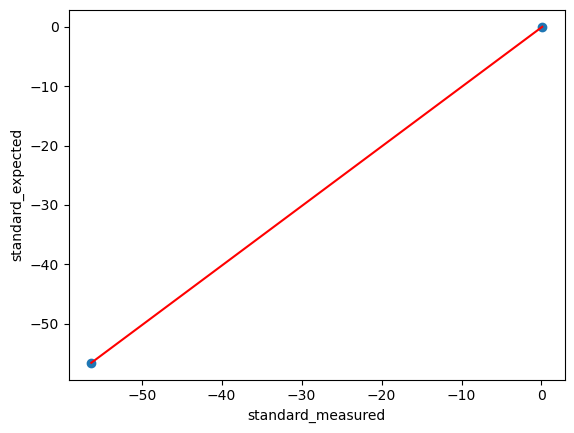

In [8]:
# First establish the standard and expected values
standard_measured = np.array([-56.3,0.1]) # This is the value you measured in lab
standard_expected = np.array([-56.6,0.0]) # this is the "true" value

# Fit a linear regression model to your data
slope, intercept, r_value, p_value, std_err = linregress(standard_measured, standard_expected)
model = {'slope': slope, 'intercept': intercept}

# Store the model in a pickle file
with open('linkam_cali_reg.pkl', 'wb') as f:
    pickle.dump(model, f)

# Plot the data along with the regression line
plt.scatter(standard_measured, standard_expected)
plt.plot(standard_measured, slope*standard_measured + intercept, color='red')
plt.xlabel('standard_measured')
plt.ylabel('standard_expected')

plt.show()

# Load in your FI data

In [9]:
import os
FI_data=pd.read_excel(os.getcwd()+'\Microthermometry Raela version.xlsx')
FI_data

,Sample,"Homogenized_to (V for vapor, L for liquid)",Th_low,Th_high,Tm_low,Tm_high,Frozen temp,Comment
0,L11_FI_M2A,NaN,NaN,NaN,-56.3,-56.2,70,NaN
1,L11_FI_M2B,NaN,NaN,NaN,-56.3,-56.2,-94,NaN
2,L11_FI_M2C,NaN,NaN,NaN,-56.4,-56.3,-94,NaN
3,L11_FI_M2D,NaN,NaN,NaN,-56.2,-56.1,-94,NaN
4,L11_FI_M4A,NaN,NaN,NaN,-56.3,-56.2,-68,NaN
5,L11_FI_M4B,NaN,NaN,NaN,-56.3,-56.1,-98,NaN
6,L11_FI_M4C,NaN,NaN,NaN,-56.3,-56.2,-85,NaN
7,L1_FI_M2A,NaN,NaN,NaN,-56.4,-56.2,-96,NaN
8,L1_FI_M2B,NaN,NaN,NaN,-56.4,-56.3,-94,NaN
9,L1_FI_M3A,NaN,NaN,NaN,-57.1,-57.0,-100,NaN


# Now load the correction model you just created

In [10]:
# Load the model from the pickle file
with open('linkam_cali_reg.pkl', 'rb') as f:
    model = pickle.load(f)

# Correct temperatures and calculate CO2 densities

In [11]:
# Function to correct temperatures and calculate CO2 density

def microtherm_correct_T_calc_CO2dens(df, model, columns_to_correct, density_columns, homog_to):
    """
    Function to correct temperatures and calculate CO2 density.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing temperature data.
    - model (dict): the pickle correction model for the Linkam.
    - columns_to_correct (list): List of column names in df containing temperatures to be corrected.
    - density_columns (list): List of column names in df containing corrected temperatures to use for CO2 density calculation.
    - homog_to (str or pd.Series): the phase to which the FI homogenized (L for liquid, V for vapor or a column name in df which contains L or V for each FI.

    Returns:
    pd.DataFrame: The input DataFrame with additional columns for corrected temperatures and CO2 densities.

    Example:
    corrected_df = microtherm_correct_T_calc_CO2dens(df, model, ['temp1', 'temp2'], ['temp1_corrected', 'temp2_corrected'], 'V')
    """

    def calc_T_correction(*, model, Th):
        """
        Helper function to calculate temperature correction.

        Parameters:
        - model (dict): A dictionary representing the temperature correction model with keys 'slope' and 'intercept'.
        - Th (float or pd.Series): The input temperature or a column in df representing temperatures.

        Returns:
        float or pd.Series: The corrected temperature.

        Example:
        corrected_temp = calc_T_correction(model=model, Th=df['temp'])
        """
        Th_array = np.array(Th)
        T_cal = model['slope'] * Th_array + model['intercept']
        return T_cal

    # Apply correction
    for col in columns_to_correct:
        new_col_name = 'corrected_' + col
        df[new_col_name] = df[col].apply(lambda x: calc_T_correction(model=model, Th=x))

    # Perform CO2 density calculation
    for col in density_columns:
        new_col_name = col + '_CO2dens_gcm3'
        homog_input = homog_to if homog_to in ['V', 'L'] else df[homog_to]
        df[new_col_name] = pf.calculate_CO2_density_homog_T(
            T_h_C=df[col],
            homog_to=homog_input,
            EOS='SW96')['Bulk_gcm3']

    return df


In [12]:
columns_to_correct = ['Th_low', 'Th_high', 'Tm_low', 'Tm_high'] # Which columns of temperature you want to correct
density_columns = ['corrected_Th_low', 'corrected_Th_high'] # Which columns you want to calculate CO2 densities for
model = model # your pickle model from before
homog_to='L'

## Now calculate everything
FI_data_corrected = microtherm_correct_T_calc_CO2dens(FI_data, model, columns_to_correct, density_columns,homog_to='Homogenized_to (V for vapor, L for liquid)')

# and calculate mean bulk density along with the range (considering the low and high values from cycling)
FI_data_corrected['Mean_Bulk_CO2dens_gcm3']=FI_data_corrected[['corrected_Th_low_CO2dens_gcm3', 'corrected_Th_high_CO2dens_gcm3']].mean(axis=1)
FI_data_corrected['Range_Bulk_CO2dens_gcm3']=abs(FI_data_corrected['corrected_Th_low_CO2dens_gcm3']-FI_data_corrected['corrected_Th_high_CO2dens_gcm3'])

FI_data_corrected

,Sample,"Homogenized_to (V for vapor, L for liquid)",Th_low,Th_high,Tm_low,Tm_high,Frozen temp,Comment,corrected_Th_low,corrected_Th_high,corrected_Tm_low,corrected_Tm_high,corrected_Th_low_CO2dens_gcm3,corrected_Th_high_CO2dens_gcm3,Mean_Bulk_CO2dens_gcm3,Range_Bulk_CO2dens_gcm3
0,L11_FI_M2A,NaN,NaN,NaN,-56.3,-56.2,70,NaN,NaN,NaN,-56.600000,-56.499645,NaN,NaN,NaN,NaN
1,L11_FI_M2B,NaN,NaN,NaN,-56.3,-56.2,-94,NaN,NaN,NaN,-56.600000,-56.499645,NaN,NaN,NaN,NaN
2,L11_FI_M2C,NaN,NaN,NaN,-56.4,-56.3,-94,NaN,NaN,NaN,-56.700355,-56.600000,NaN,NaN,NaN,NaN
3,L11_FI_M2D,NaN,NaN,NaN,-56.2,-56.1,-94,NaN,NaN,NaN,-56.499645,-56.399291,NaN,NaN,NaN,NaN
4,L11_FI_M4A,NaN,NaN,NaN,-56.3,-56.2,-68,NaN,NaN,NaN,-56.600000,-56.499645,NaN,NaN,NaN,NaN
5,L11_FI_M4B,NaN,NaN,NaN,-56.3,-56.1,-98,NaN,NaN,NaN,-56.600000,-56.399291,NaN,NaN,NaN,NaN
6,L11_FI_M4C,NaN,NaN,NaN,-56.3,-56.2,-85,NaN,NaN,NaN,-56.600000,-56.499645,NaN,NaN,NaN,NaN
7,L1_FI_M2A,NaN,NaN,NaN,-56.4,-56.2,-96,NaN,NaN,NaN,-56.700355,-56.499645,NaN,NaN,NaN,NaN
8,L1_FI_M2B,NaN,NaN,NaN,-56.4,-56.3,-94,NaN,NaN,NaN,-56.700355,-56.600000,NaN,NaN,NaN,NaN
9,L1_FI_M3A,NaN,NaN,NaN,-57.1,-57.0,-100,NaN,NaN,NaN,-57.402837,-57.302482,NaN,NaN,NaN,NaN


# Now let's plot the data

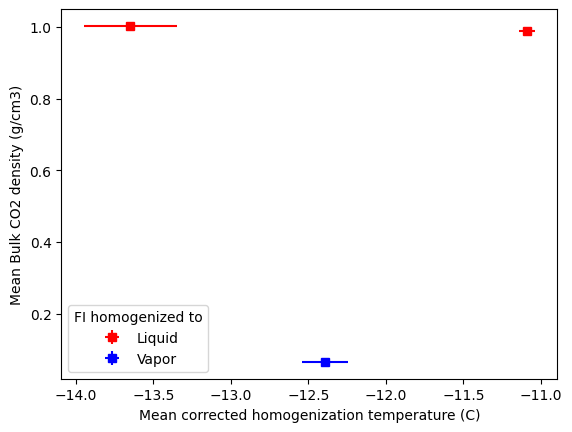

In [ ]:
# First group by which phase the FI homogenized to
grouped_data = FI_data_corrected.groupby('Homogenized_to (V for vapor, L for liquid)')

# Then plot
for group, data in grouped_data:
    color = 'blue' if group == 'V' else 'red'
    label = 'Vapor' if group == 'V' else 'Liquid'
    plt.errorbar(
        data[['corrected_Th_low', 'corrected_Th_high']].mean(axis=1),
        data['Mean_Bulk_CO2dens_gcm3'],
        yerr=data['Range_Bulk_CO2dens_gcm3'] / 2,
        xerr=abs(data['corrected_Th_low'] - data['corrected_Th_high']) / 2,
        linestyle='None',
        fmt='s',
        color=color,
        label=label
    )
plt.xlabel('Mean corrected homogenization temperature (C)')
plt.ylabel('Mean Bulk CO2 density (g/cm3)')
plt.legend(title='FI homogenized to',loc='lower left')
plt.show()

